/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.war

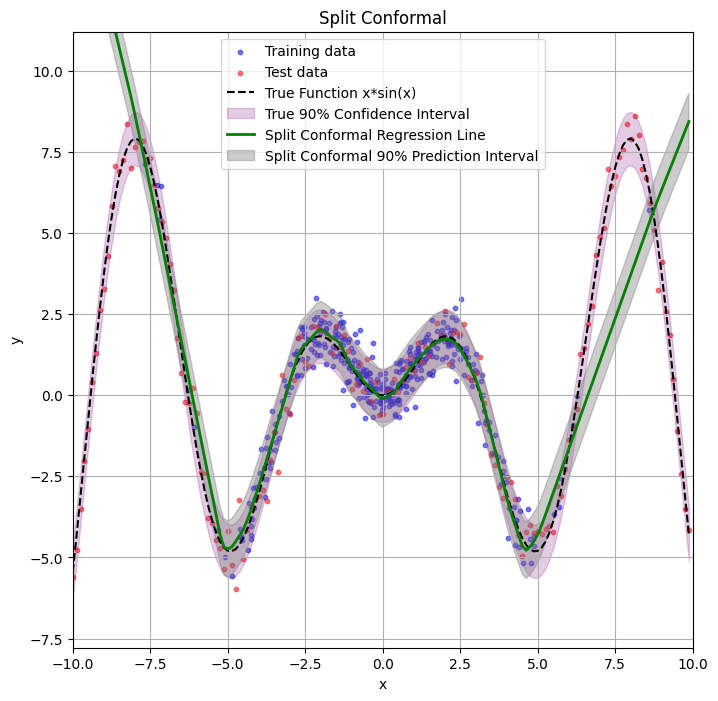

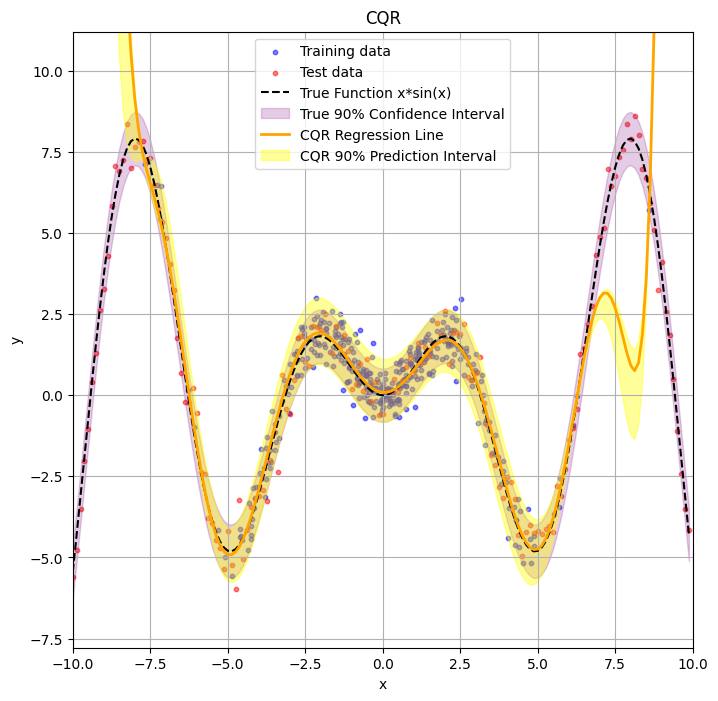

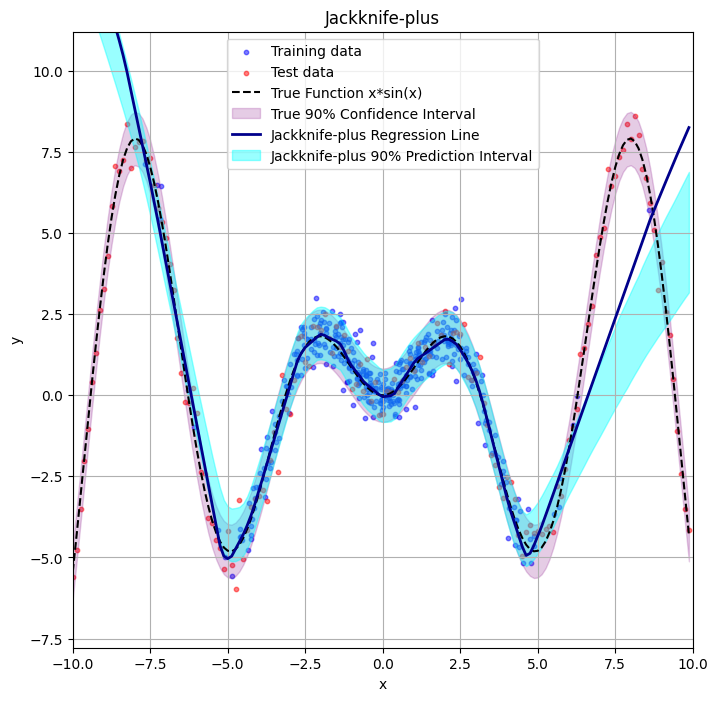

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import QuantileRegressor
from mapie.regression import MapieRegressor, MapieQuantileRegressor
from mapie.subsample import Subsample
from mapie.metrics import regression_coverage_score, regression_mean_width_score
import matplotlib.pyplot as plt
from typing import Callable, Tuple, TypeVar, Any
from numpy.typing import NDArray

F = TypeVar("F", bound=Callable[..., Any])
random_state = 40

def x_sinx(x: NDArray) -> NDArray:
    """One-dimensional x*sin(x) function."""
    return x * np.sin(x)

def get_1d_data_with_normal_distrib(
    funct: F, mu: float, sigma: float, n_samples: int, noise: float
) -> Tuple[NDArray, NDArray, NDArray, NDArray, NDArray]:
    np.random.seed(random_state)
    X_train = np.random.normal(mu, sigma, n_samples)
    X_test = np.arange(mu - 4 * sigma, mu + 4 * sigma, sigma / 20.0)
    y_train = funct(X_train) + np.random.normal(0, noise, size=X_train.shape)
    y_test = funct(X_test) + np.random.normal(0, noise, size=X_test.shape)
    y_mesh = funct(X_test)
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

mu, sigma, n_samples, noise = 0, 2.5, 400, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_normal_distrib(x_sinx, mu, sigma, n_samples, noise)

nn_regressor = MLPRegressor(hidden_layer_sizes=(64, 64, 64), activation='relu', solver='adam', max_iter=1000, random_state=40)
x_trainspli, x_calib, y_trainspli, y_calib = train_test_split(X_train, y_train, test_size=0.25, random_state=30)
nn_regressor.fit(x_trainspli, y_trainspli)

# Split Conformal
mapie_split = MapieRegressor(nn_regressor, method="naive", cv="split")
mapie_split.fit(x_trainspli, y_trainspli)
y_pred_split, y_pis_split = mapie_split.predict(X_test, alpha=0.1)

# Conformalized Quantile Regression
degree_polyn = 10
polyn_model_quant = Pipeline([
    ("poly", PolynomialFeatures(degree=degree_polyn)),
    ("linear", QuantileRegressor(solver="highs", alpha=0))
])
mapie_cqr = MapieQuantileRegressor(polyn_model_quant, method="quantile", cv="split", alpha=0.1)
mapie_cqr.fit(X_train, y_train, X_calib=x_calib, y_calib=y_calib, random_state=2)
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_test)

# Jackknife-plus
mapie_jackknife = MapieRegressor(nn_regressor, method="plus", cv=Subsample(n_resamplings=50))
mapie_jackknife.fit(x_trainspli, y_trainspli)
y_pred_jackknife, y_pis_jackknife = mapie_jackknife.predict(X_test, alpha=0.1)

# Sorting for plotting
sorted_indices = np.argsort(X_test.flatten())
X_test_sorted = X_test[sorted_indices]
y_true_function = x_sinx(X_test_sorted)
lower_true_ci = y_true_function - 1.645 * noise
upper_true_ci = y_true_function + 1.645 * noise

def plot_results(method_name, y_pred_sorted, y_pis_sorted, color_line, color_fill):
    plt.figure(figsize=(8, 8))
    plt.scatter(X_train, y_train, s=10, c='blue', label='Training data', alpha=0.5)
    plt.scatter(X_test, y_test, s=10, c='red', label='Test data', alpha=0.5)
    plt.plot(X_test_sorted, y_true_function, color='black', linestyle='--', label='True Function x*sin(x)')
    plt.fill_between(X_test_sorted.flatten(), lower_true_ci.flatten(), upper_true_ci.flatten(), color='purple', alpha=0.2, label='True 90% Confidence Interval')
    plt.plot(X_test_sorted, y_pred_sorted, color=color_line, linewidth=2, label=f'{method_name} Regression Line')
    plt.fill_between(X_test_sorted.flatten(), y_pis_sorted[:, 0].flatten(), y_pis_sorted[:, 1].flatten(), color=color_fill, alpha=0.4, label=f'{method_name} 90% Prediction Interval')
    plt.title(f'{method_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.xlim([-10, 10])
    plt.ylim([np.min(y_test) * 1.3, np.max(y_test) * 1.3])
    plt.show()

plot_results("Split Conformal", y_pred_split[sorted_indices], y_pis_split[sorted_indices], 'green', 'gray')
plot_results("CQR", y_pred_cqr[sorted_indices], y_pis_cqr[sorted_indices, :, 0], 'orange', 'yellow')
plot_results("Jackknife-plus", y_pred_jackknife[sorted_indices], y_pis_jackknife[sorted_indices], 'darkblue', 'cyan')
